In [1]:
import sympy as sym

import numpy as np

import itertools

sym.init_printing()

In [2]:
from importlib.machinery import SourceFileLoader


evolution = SourceFileLoader("evolution", "src/evolution.py").load_module()
formulation = SourceFileLoader("formulation", "src/formulation.py").load_module()

simulation = SourceFileLoader("simulation", "src/simulation.py").load_module()

In [3]:
import matplotlib.pyplot as plt
import matplotlib

from collections import Counter

In [4]:
from tqdm import tqdm

In [5]:
import pandas as pd

**Defining variables**

In [6]:
y_1, p_1, q_1 = sym.symbols("y_1, p_1, q_1")
y_2, p_2, q_2 = sym.symbols("y_2, p_2, q_2")

In [7]:
s_one = (y_1, p_1, q_1)
s_two = (y_2, p_2, q_2)

In [8]:
s_one

In [9]:
combinations = itertools.product([s_one, s_two], repeat=2)

In [10]:
list(combinations)

**Get expression using code**

In [28]:
d = sym.symbols("delta")

In [29]:
v_zero = formulation.expected_distribution_opening_round(s_one, s_two)

In [30]:
v_zero

In [31]:
M = formulation.markov_chain_for_reactive_strategies(s_one, s_two)

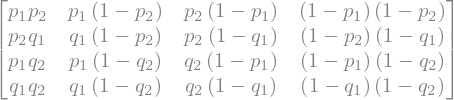

In [32]:
sym.Matrix(M)

In [33]:
inverse = sym.Matrix(np.identity(4) - d * M).inverse_ADJ()

In [34]:
expression = (1 - d) * sym.Matrix(v_zero).reshape(1, 4) @ inverse

**Check the written mathematics**

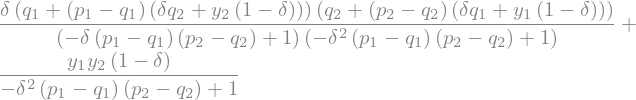

In [35]:
u_R = formulation.probability_being_in_state_R(s_one, s_two, d)
u_R

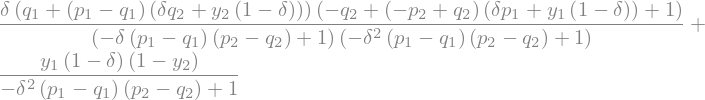

In [36]:
u_S = formulation.probability_being_in_state_S(s_one, s_two, d)
u_S

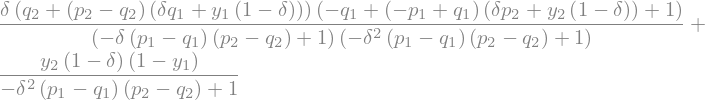

In [37]:
u_T = formulation.probability_being_in_state_T(s_one, s_two, d)
u_T

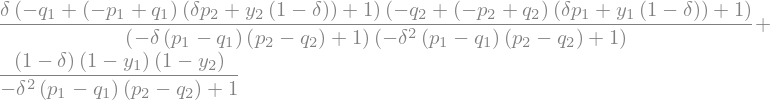

In [38]:
u_P = formulation.probability_being_in_state_P(s_one, s_two, d)
u_P

In [39]:
(u_R - expression[0]).simplify(), (u_S - expression[1]).factor()

In [40]:
(u_T - expression[2]).factor(), (u_P - expression[3]).factor()

**Check functions for analysis of ALLD into GTFT**

In [41]:
q = sym.symbols("q")

N, k = sym.symbols("N, k")

In [42]:
ALLD = (0, 0, 0)
GTFT = (1, 1, q)

**States of Eq. (9) and (10)**

In [43]:
formulation.probability_being_in_state_R(GTFT, GTFT, d).factor()

In [44]:
formulation.probability_being_in_state_R(GTFT, ALLD, d).factor()

In [45]:
formulation.probability_being_in_state_R(GTFT, ALLD, d).factor()

In [46]:
formulation.probability_being_in_state_T(ALLD, GTFT, d).factor()

In [47]:
(
    formulation.probability_being_in_state_S(GTFT, GTFT, d).factor(),
    formulation.probability_being_in_state_T(GTFT, GTFT, d).factor(),
    formulation.probability_being_in_state_P(GTFT, GTFT, d).factor(),
)

In [50]:
formulation.probability_being_in_state_R(ALLD, GTFT, d).factor(), formulation.probability_being_in_state_S(
    ALLD, GTFT, d
).factor()

In [51]:
formulation.probability_being_in_state_T(ALLD, GTFT, d).factor(), formulation.probability_being_in_state_P(
    ALLD, GTFT, d
).factor()

**Ep. (11)**

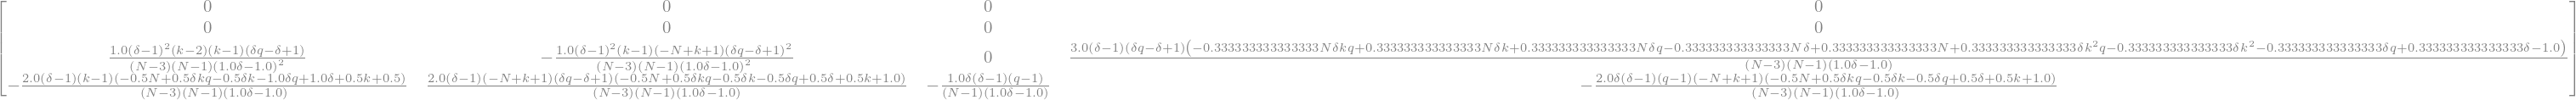

In [61]:
combinations = itertools.product([GTFT, ALLD], repeat=2)
vMM, vMR, vRM, vRR = [
        formulation.steady_state(p1, p2, d) for p1, p2 in combinations
    ]


sym.Matrix(evolution.probability_of_receiving_payoffs(vMM, vMR, vRM, vRR, k=k, N=N)).applyfunc(sym.factor)

**Simulations** - **Example in notes**

**Plotting simulation results**

In [70]:
df = pd.read_csv('expected_payoff_data.csv', header=None)

In [74]:
df.columns = ['R', 'S', 'T', 'P', 'N', 'delta', 'beta', 'mode', 'cooperation', 'score', 'y', 'p', 'q']

In [89]:
df['score'] = [float(val.replace('[', "").replace(']', "")) for val in df['score']]

In [92]:
df.describe()

,R,S,T,P,N,delta,beta,cooperation,score,y,p,q
count,54237.0,54237.0,54237.0,54237.0,54237.0,5.423700e+04,54237.0,54237.000000,54237.000000,54237.000000,54237.000000,54237.000000
mean,2.0,-1.0,3.0,0.0,100.0,9.990000e-01,1.0,0.502290,1.004579,0.442359,0.568304,0.134291
std,0.0,0.0,0.0,0.0,0.0,2.220467e-16,0.0,0.434754,0.869508,0.272739,0.409081,0.136811
min,2.0,-1.0,3.0,0.0,100.0,9.990000e-01,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.0,-1.0,3.0,0.0,100.0,9.990000e-01,1.0,0.062453,0.124906,0.276361,0.155993,0.037916
50%,2.0,-1.0,3.0,0.0,100.0,9.990000e-01,1.0,0.274866,0.549732,0.333345,0.459872,0.120022
75%,2.0,-1.0,3.0,0.0,100.0,9.990000e-01,1.0,0.983474,1.966949,0.674971,0.998380,0.139220
max,2.0,-1.0,3.0,0.0,100.0,9.990000e-01,1.0,0.997984,1.995968,0.997702,0.999756,0.999444


In [93]:
x, y = simulation._reshape_data(df)

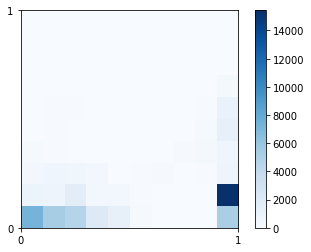

In [94]:
cmap = matplotlib.cm.get_cmap('Blues')

heatmap, xedges, yedges = np.histogram2d(x, y, bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, cmap=cmap, origin='lower')

plt.colorbar()
plt.xticks(np.linspace(0, 1, 2));
plt.yticks(np.linspace(0, 1, 2));
plt.show()

In [9]:
df = pd.read_csv('stochastic_payoff_data.csv', header=None)

In [10]:
x, y = simulation._reshape_data(df)

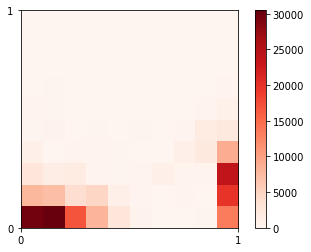

In [11]:
cmap = matplotlib.cm.get_cmap('Reds')

heatmap, xedges, yedges = np.histogram2d(x, y, bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, cmap=cmap, origin='lower');

plt.colorbar()
plt.xticks(np.linspace(0, 1, 2));
plt.yticks(np.linspace(0, 1, 2));
plt.show()